<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

https://towardsdatascience.com/how-to-get-stock-data-using-python-c0de1df17e75

In [27]:
import pandas as pd 
import matplotlib.pyplot as plt 
from collections import Counter
import matplotlib as mpl
import seaborn as sns
import numpy as np

label_size = 13
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size


In [7]:
import yfinance as yf

#define the ticker symbol
tickerSymbol = 'AAPL'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', 
                              start='2010-1-1', 
                              end='2021-7-25')

#see your data
tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-12-31,6.535605,6.542351,6.456796,6.462008,352410800,0.0,0.0
2010-01-04,6.544805,6.577616,6.512607,6.562591,493729600,0.0,0.0
2010-01-05,6.580681,6.611040,6.539283,6.573935,601904800,0.0,0.0
2010-01-06,6.573936,6.600001,6.462623,6.469369,552160000,0.0,0.0
2010-01-07,6.493286,6.500952,6.410490,6.457407,477131200,0.0,0.0
...,...,...,...,...,...,...,...
2021-07-19,143.534951,143.854480,141.458061,142.236893,121434600,0.0,0.0
2021-07-20,143.245388,146.879942,142.746136,145.931351,96350000,0.0,0.0
2021-07-21,145.312290,145.911399,144.413643,145.182480,74993500,0.0,0.0


Text(0, 0.5, 'USD')

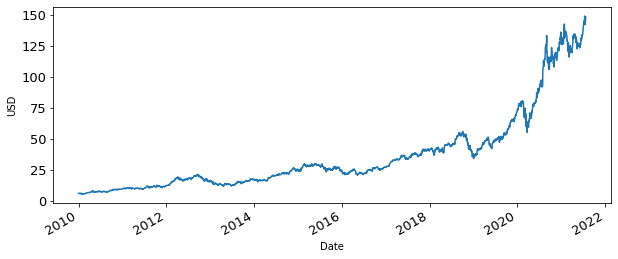

In [10]:
plt.figure(figsize=(10,4))
tickerDf['Close'].plot()
plt.ylabel("USD")

In [9]:
Counter(tickerData.recommendations['To Grade'])

Counter({'Buy': 311,
         'Outperform': 158,
         'Overweight': 128,
         'Sector Perform': 4,
         'Neutral': 81,
         'Sector Outperform': 2,
         'Hold': 39,
         'Market Perform': 24,
         '': 3,
         'Strong Buy': 8,
         'Long-term Buy': 1,
         'Sell': 8,
         'Market Outperform': 3,
         'Positive': 4,
         'Long-Term Buy': 1,
         'Equal-weight': 1,
         'Equal-Weight': 20,
         'Perform': 2,
         'Negative': 1,
         'Reduce': 1,
         'Underweight': 1,
         'Underperform': 1,
         'Sector Weight': 2})

<AxesSubplot:xlabel='Date'>

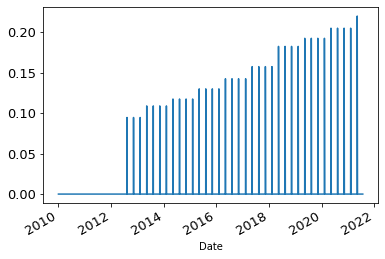

In [16]:
tickerDf

In [17]:
df = tickerDf.copy()

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print(column_indices, num_features)

{'Open': 0, 'High': 1, 'Low': 2, 'Close': 3, 'Volume': 4, 'Dividends': 5, 'Stock Splits': 6} 7


In [18]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

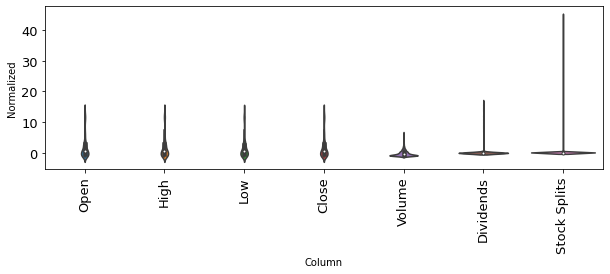

In [20]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(10, 3))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [15]:
import tensorflow as tf 

Init Plugin
Init Graph Optimizer
Init Kernel


Metal device set to: Apple M1


2021-08-25 11:09:53.738221: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-25 11:09:53.738409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [29]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [30]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]

    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [143]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
    inputs, labels = self.example

    plt.figure(figsize=(12, 6))
    plot_col_index = self.column_indices[plot_col]
    print(plot_col_index)
    
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)

        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

#        label_col_index = self.label_columns_indices.get(plot_col, None)
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
            
        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n+100, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)

        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n+100, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
            
        if n==1: 
            plt.ylabel(f'{plot_col} [normed]')

        plt.xlabel('Time [days]')

WindowGenerator.plot = plot

In [144]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [145]:

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    
    result = getattr(self, '_example', None)
    
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [146]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [147]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Close']

In [148]:
baseline = Baseline(label_index=column_indices['Close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, 
                                            verbose=0)

19/19 [==============================] - 0s 3ms/step - loss: 0.0190 - mean_absolute_error: 0.0870


2021-08-25 14:28:00.094136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [149]:
MAX_EPOCHS = 400

def compile_and_fit(model, window, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [150]:
linear = tf.keras.Sequential([
        tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/400
30/64 [=============>................] - ETA: 0s - loss: 2.1026 - mean_absolute_error: 0.8166

2021-08-25 14:28:00.672783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 1s 7ms/step - loss: 1.3921 - mean_absolute_error: 0.7404 - val_loss: 9.7154 - val_mean_absolute_error: 2.8716
Epoch 2/400
10/64 [===>..........................] - ETA: 0s - loss: 0.5594 - mean_absolute_error: 0.6006

2021-08-25 14:28:01.084563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 0s 7ms/step - loss: 1.0023 - mean_absolute_error: 0.5335 - val_loss: 5.3733 - val_mean_absolute_error: 2.1084
Epoch 3/400
64/64 [==============================] - 0s 6ms/step - loss: 0.7857 - mean_absolute_error: 0.3843 - val_loss: 2.9409 - val_mean_absolute_error: 1.5308
Epoch 4/400
64/64 [==============================] - 0s 6ms/step - loss: 0.6724 - mean_absolute_error: 0.2870 - val_loss: 1.6622 - val_mean_absolute_error: 1.1200
Epoch 5/400
64/64 [==============================] - 0s 6ms/step - loss: 0.6117 - mean_absolute_error: 0.2277 - val_loss: 0.9765 - val_mean_absolute_error: 0.8328
Epoch 6/400
64/64 [==============================] - 0s 6ms/step - loss: 0.5740 - mean_absolute_error: 0.1914 - val_loss: 0.6225 - val_mean_absolute_error: 0.6449
Epoch 7/400
64/64 [==============================] - 0s 6ms/step - loss: 0.5456 - mean_absolute_error: 0.1657 - val_loss: 0.4301 - val_mean_absolute_error: 0.5218
Epoch 8/400
64/64 [===============

In [151]:
wide_window = WindowGenerator(
    input_width=40, label_width=40, shift=1,
    label_columns=['Close'])

wide_window

Total window size: 41
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Label column name(s): ['Close']

3


InvalidArgumentError: slice index 100 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

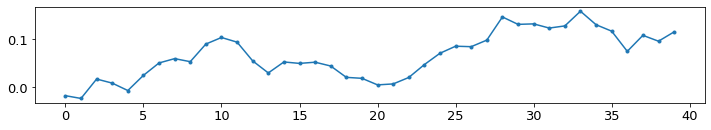

In [152]:
wide_window.plot(linear)

In [ ]:
CONV_WIDTH = 3
label_width = 40
input_width = label_width + (CONV_WIDTH - 1)

conv_window = WindowGenerator(
    input_width=input_width,
    label_width=label_width,
    shift=1,
    label_columns=['Close'])

conv_window

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
history = compile_and_fit(conv_model, conv_window)

#IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

In [ ]:
conv_window.plot(conv_model)

In [ ]:

lstm_window = WindowGenerator(
    input_width=40,
    label_width=40,
    shift=1,
    label_columns=['Close'])

lstm_window

In [ ]:

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


history = compile_and_fit(lstm_model, lstm_window)


In [ ]:
lstm_window.plot(lstm_model)

3


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

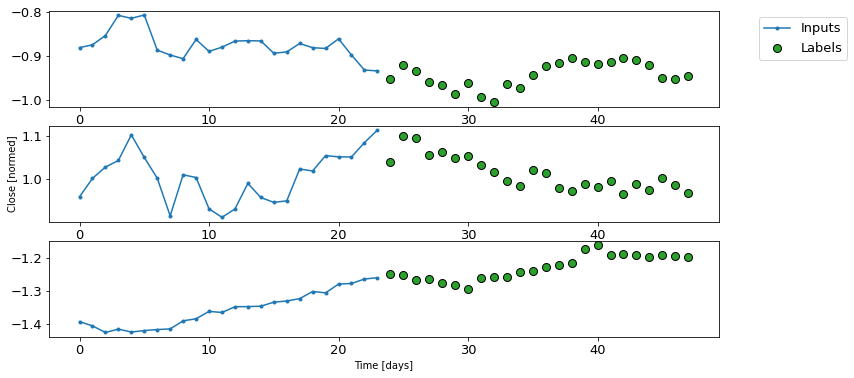

In [121]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

17/17 [==============================] - 0s 3ms/step - loss: 1.0466 - mean_absolute_error: 0.2824


2021-08-25 11:44:59.521655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3


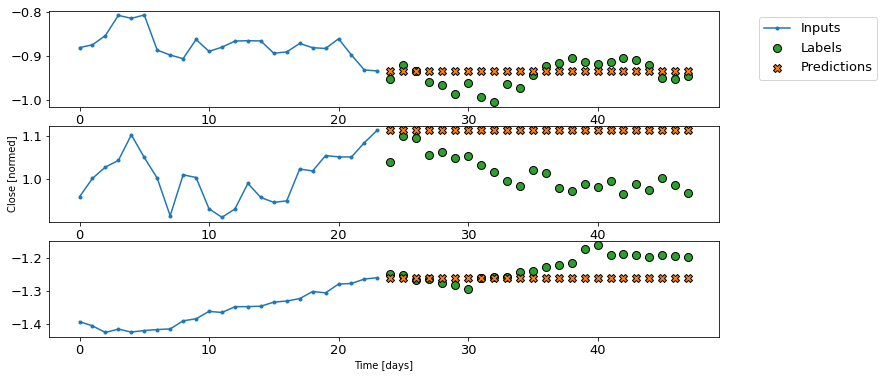

In [122]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

17/17 [==============================] - 0s 3ms/step - loss: 1.1942 - mean_absolute_error: 0.4037
3


2021-08-25 14:28:22.641425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


InvalidArgumentError: slice index 100 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

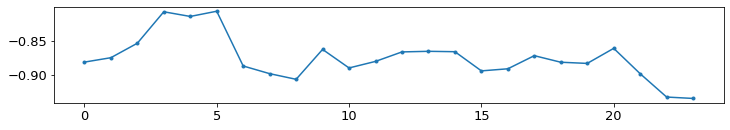

In [153]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

#IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

Epoch 1/400
15/63 [======>.......................] - ETA: 0s - loss: 0.5393 - mean_absolute_error: 0.3537

2021-08-25 14:28:30.348799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 1s 10ms/step - loss: 0.4259 - mean_absolute_error: 0.2257 - val_loss: 0.8732 - val_mean_absolute_error: 0.4866
Epoch 2/400
 8/63 [==>...........................] - ETA: 0s - loss: 0.2813 - mean_absolute_error: 0.1650

2021-08-25 14:28:30.936168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 1s 9ms/step - loss: 0.3685 - mean_absolute_error: 0.1604 - val_loss: 0.7064 - val_mean_absolute_error: 0.3913
Epoch 3/400
63/63 [==============================] - 1s 10ms/step - loss: 0.3667 - mean_absolute_error: 0.1603 - val_loss: 0.6684 - val_mean_absolute_error: 0.3439
Epoch 4/400
63/63 [==============================] - 1s 9ms/step - loss: 0.3653 - mean_absolute_error: 0.1603 - val_loss: 0.6637 - val_mean_absolute_error: 0.3486
Epoch 5/400
63/63 [==============================] - 1s 9ms/step - loss: 0.3642 - mean_absolute_error: 0.1597 - val_loss: 0.6752 - val_mean_absolute_error: 0.3672
Epoch 6/400
63/63 [==============================] - 1s 9ms/step - loss: 0.3630 - mean_absolute_error: 0.1605 - val_loss: 0.6405 - val_mean_absolute_error: 0.3329
Epoch 7/400
63/63 [==============================] - 1s 9ms/step - loss: 0.3624 - mean_absolute_error: 0.1596 - val_loss: 0.6452 - val_mean_absolute_error: 0.3394
Epoch 8/400
63/63 [==============

InvalidArgumentError: slice index 100 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

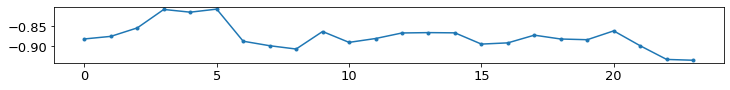

In [154]:
CONV_WIDTH = 7

from keras.layers.convolutional import MaxPooling1D


multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(1024, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

#IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model, max_subplots=5)